In [1]:
from config import *
from utils.db_connection import create_connection, query_data, query_sql_file, select_table
from src.data import process_vital_signs

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Connect to MIMIC-III dataset
con = create_connection()

### Vital Signs monitored each hour for the 1st day of admission

In [ ]:
script = query_sql_file(os.path.join(SCRIPTS_VITAL_SIGNS_DIR, 'vital_signs_per_hour.sql'), con)
original_df = query_data(script[0], con)
original_df.head()

#### Pre-processing

In [ ]:
# remove entries where no vital id is specified
original_df.dropna(subset=['vitalid'], inplace=True)

# assign actual vital sign label to each vital id
original_df = process_vital_signs.replace_vital_labels(original_df)

# # remove vital id feature
# df.drop(columns=['vitalid'], inplace=True)
original_df.head()

In [6]:
# Get the admission time for each hadm_id
query = \
"""
SELECT hadm_id, admittime, hospital_expire_flag
FROM admissions;
"""
admissions = query_data(query, con)

In [ ]:
original_df = pd.merge(original_df, admissions, on=['hadm_id'], how='left')
original_df.head()

In [ ]:
### Calculate the hour since admission instead of the actual datetime
original_df['hours_since_admission'] = (original_df['chart_hour'] - original_df['admittime']).dt.total_seconds() // 3600

original_df.drop(columns=['chart_hour', 'admittime'], inplace=True)

### For multiple monitored signs per hour, take the average
df = original_df.groupby(['hadm_id', 'icustay_id', 'vitalid', 'vital_sign', 'hours_since_admission'], as_index=False).agg({
    'valuenum': 'mean',
    'hospital_expire_flag': 'max'
})
df['hours_since_admission'] = df['hours_since_admission'].astype('int')
df.head()

In [9]:
df.to_csv(os.path.join(PROCESSED_DATA_DIR, 'vital_signs_per_hour.csv'))

In [ ]:
df.head()

### Correlation Matrix - Vital Signs

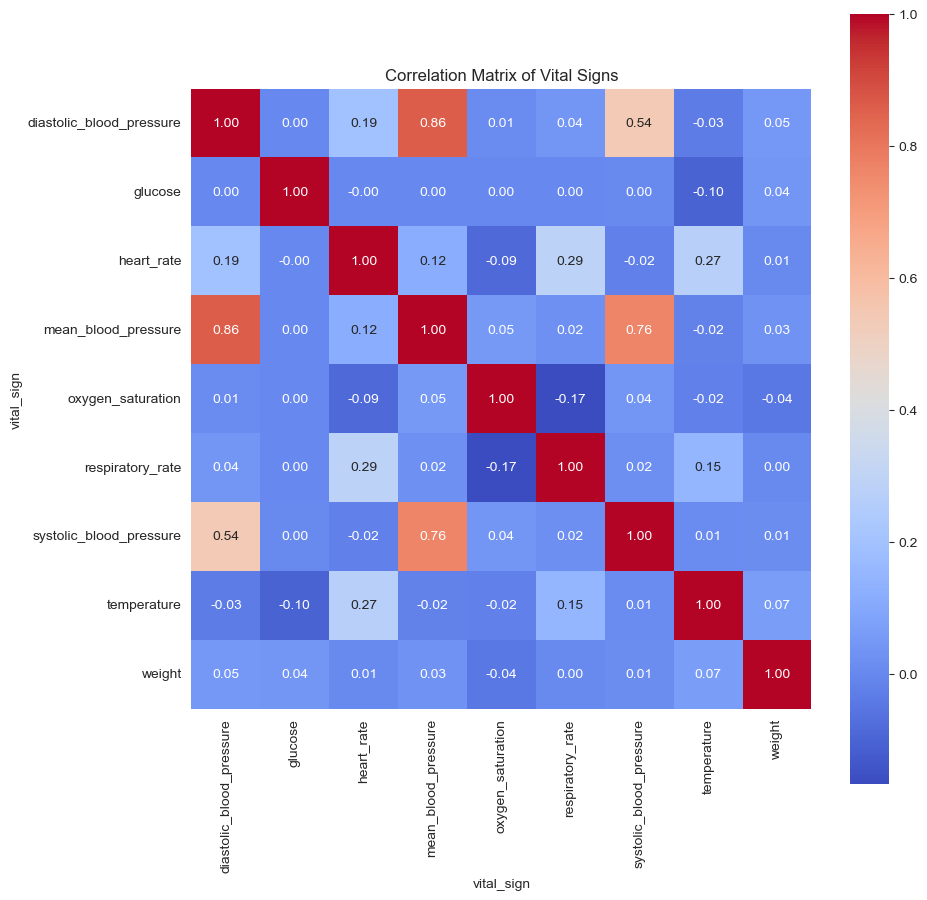

In [11]:
import seaborn as sns

pivot_df = df.pivot_table(index=['hadm_id', 'hours_since_admission'], columns='vital_sign', values='valuenum')
corr_matrix = pivot_df.corr()

# Let's visualize this correlation matrix using a heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", square=True, cmap = 'coolwarm')
plt.title("Correlation Matrix of Vital Signs")
plt.savefig(os.path.join(FIG_VITAL_SIGNS_DIR, '02_Corr Matrix of Vital Signs.png'))
plt.show()

### Hospital Mortality based on Vital Signs

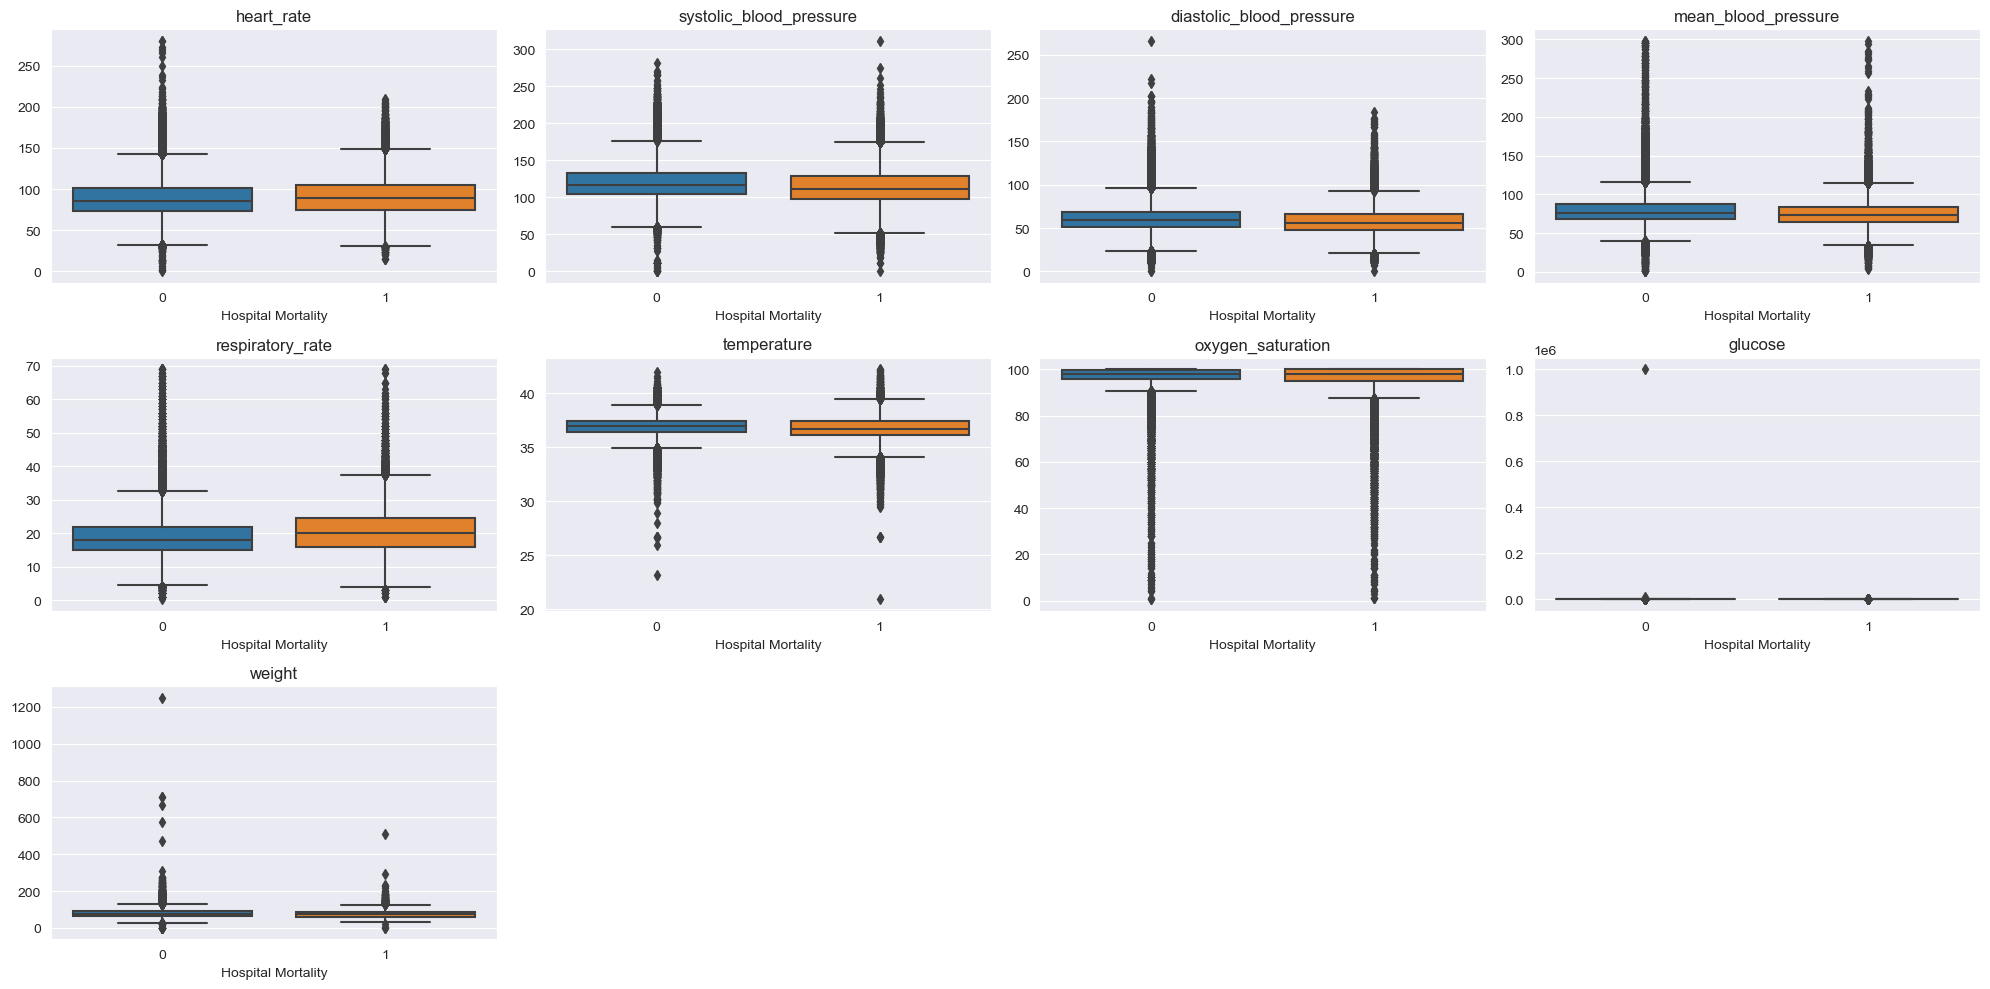

In [12]:
vital_signs = df['vital_sign'].unique()
fig, axes = plt.subplots(3, 4, figsize=(20,10))
axes = axes.flatten()

# Plot each vital sign
for ax, vital_sign in zip(axes, vital_signs):
    df_vital = df[df['vital_sign'] == vital_sign]  # filter the DataFrame for the current vital sign
    sns.boxplot(x='hospital_expire_flag', y='valuenum', data=df_vital, ax=ax)  # showfliers=False hides outliers
    ax.set_title(vital_sign)
    ax.set_xlabel('Hospital Mortality')
    ax.set_ylabel('')

# Remove unused subplots
for i in range(len(vital_signs), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
# plt.savefig(f'{img_path}/vital_signs_mortality.png')
plt.show()

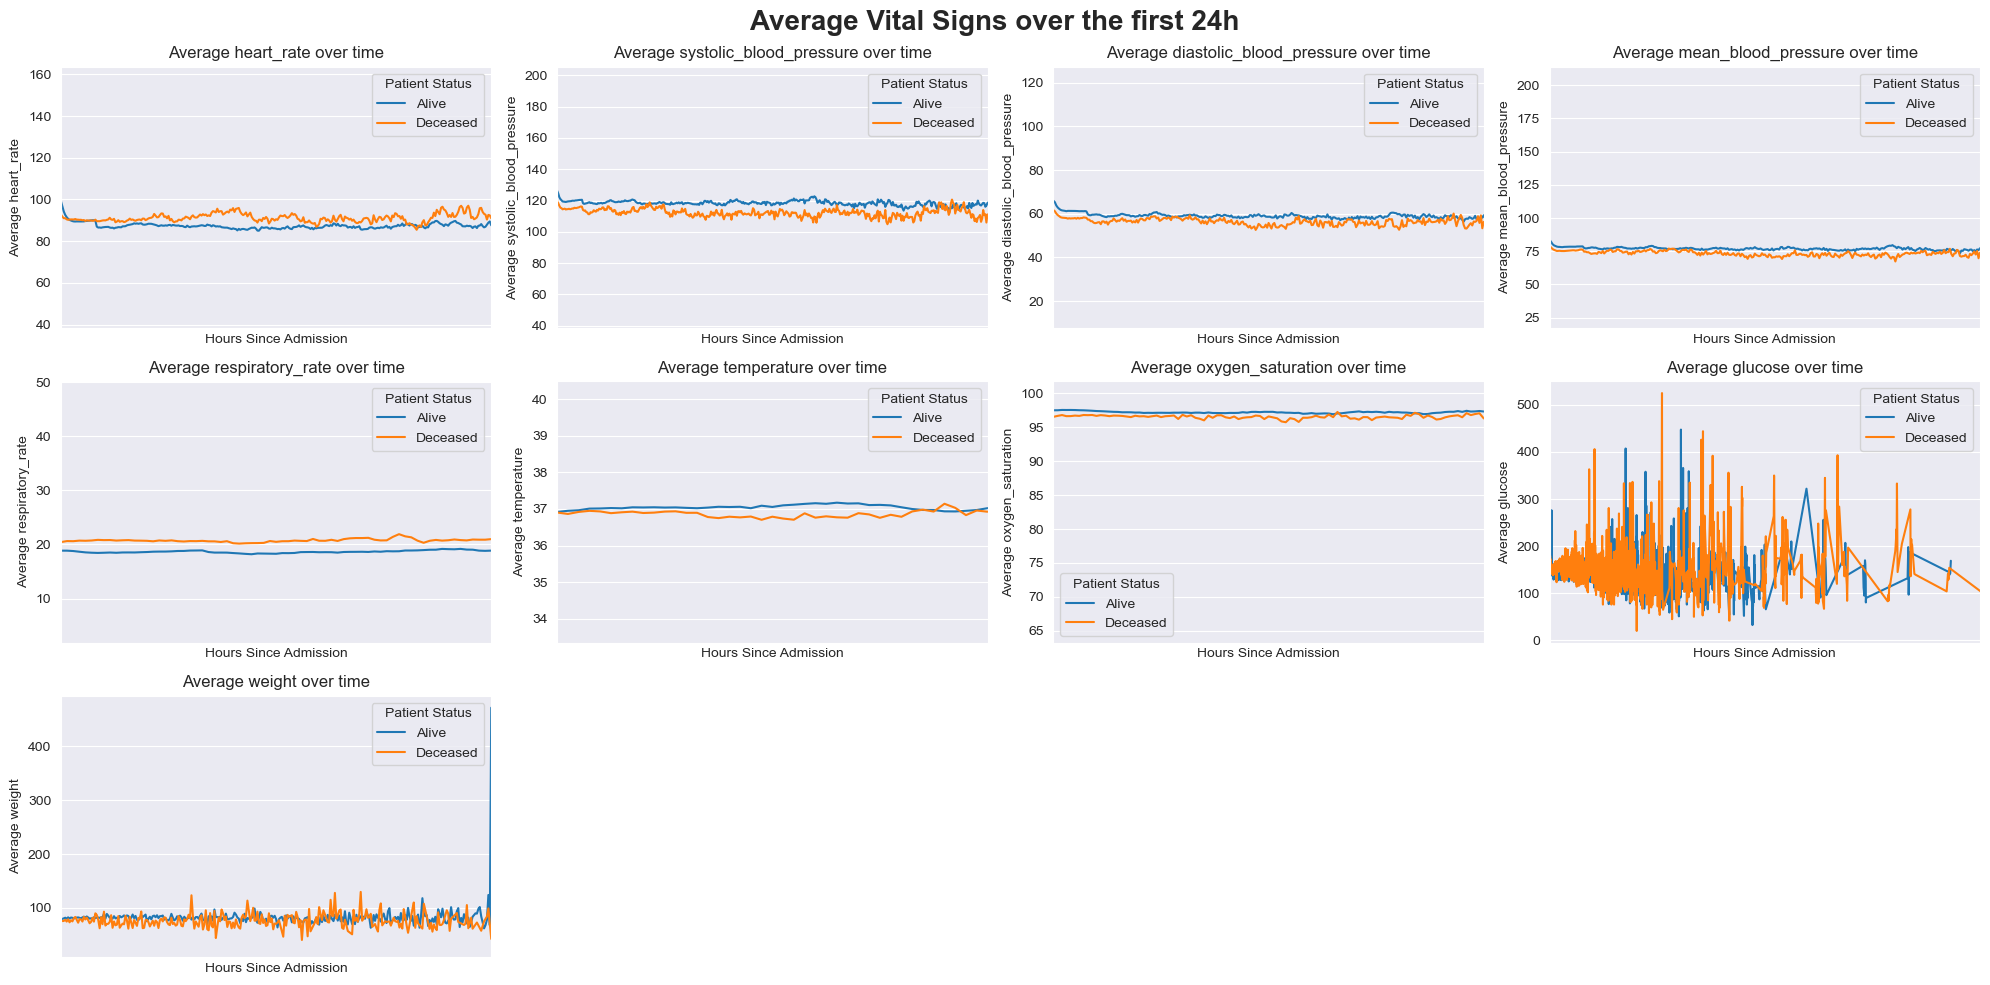

In [13]:
fig, axes = plt.subplots(3, 4, figsize=(20,10))
axes = axes.flatten()

limits = process_vital_signs.define_limits()

fig.suptitle('Average Vital Signs over the first 24h', fontsize=20, fontweight='bold')
for ax, vital_sign in zip(axes, limits):
    df_vital = df[df['vital_sign'] == vital_sign]  # filter the DataFrame for the current vital sign
    grouped_df = df_vital.groupby(['hospital_expire_flag', 'hours_since_admission'])['valuenum'].mean().reset_index()
    for label, group in grouped_df.groupby('hospital_expire_flag'):
        ax.plot(group['hours_since_admission'], group['valuenum'], label='Alive' if label == 0 else 'Deceased')
    ax.set_title(f"Average {vital_sign} over time")
    ax.set_xlabel('Hours Since Admission')
    ax.set_ylabel(f'Average {vital_sign}')
    ax.set_xlim(limits[vital_sign])
    ax.set_xticks([])
    ax.legend(title='Patient Status')

for i in range(len(limits), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.savefig(os.path.join(FIG_VITAL_SIGNS_DIR, '03_Vital Signs over the first 24h.png'))
plt.show()

In [14]:
# process_vital_signs.visualize_over_time(df=df, vital_sign='heart_rate', limits=[0, 300])

In [15]:
# process_vital_signs.visualize_over_time(df=df, vital_sign='systolic_blood_pressure', limits=[0, 400])

In [16]:
# # Convert the 'valuenum' column to a list for each hadm_id and vital sign
# df_grouped = df.groupby(['hadm_id', 'vital_sign'])['valuenum'].apply(list).reset_index()
#
# # Pivot the table so that each vital sign becomes a column
# df_pivoted = df_grouped.pivot(index='hadm_id', columns='vital_sign', values='valuenum')
#
# # Reset the index
# df_pivoted.reset_index(inplace=True)
#
# df_pivoted.drop(columns=['arterial_ph', 'weight'], inplace=True)
# df_pivoted.head()

In [17]:
# df_pivoted.isnull().sum()

In [18]:
# # df_3d = df.pivot_table(values='valuenum', index=['hadm_id', 'chart_hour'], columns='vital_sign')
# # df_3d

In [19]:
# patient_data = pd.read_csv('../dataset/patient_stay_data.csv')
# final_df = pd.merge(df_pivoted, patient_data, on='hadm_id', how='left')
# final_df.head()

In [20]:
# df_pivoted = df_pivoted.drop_duplicates(subset='hadm_id')
# final_df = pd.merge(df_pivoted, patient_data, on='hadm_id', how='left')
# final_df.head()